# Modeling a Pipeline Network with JuMP
### Jordan Jalving and Victor Zavala

![title](13_pipe_sketch.png)

## Import packages

In [2]:
using JuMP
using Ipopt
using PyPlot

# Physical property data

In [3]:
eps= 0.025		             # pipe rugosity - [mm]
z= 0.80        			     # gas compressibility  - []
rhon=0.72         		     # density of air at normal conditions - [kg/m3]
R=8314.0       			     # universal gas constant [J/kgmol-K]
M=18.0    			         # gas molar mass [kg/kgmol]
pi=3.14         		     # pi
T = 293.15      		     # reference temperature [K]
Cp = 2.34        		     # heat capacity @ constant pressure [kJ/kg-K]
Cv = 1.85        		     # heat capacity @ constant volume [kJ/kg-K]

#scaling factors
ffac=(1e+6*rhon)/(24*3600)                     # from scmx10-6/day to kg/s
ffac2=(3600)/(1e+4*rhon)                       # from kg/s to scmx10-4/hr
pfac=1e+5                                      # from bar to Pa
pfac2=1e-5                                     # from Pa to bar
dfac=1e-3                                      # from mm to m
lfac=1e+3;                                      # from km to m

## Define sets of nodes and links

$\mathcal{N}$: Set of nodes in the gas network (junctions) 

$\mathcal{L}$: Set of links (pipelines)

$\mathcal{S} \subseteq \mathcal{N}$: Set of gas supplies

$\mathcal{D} \subseteq \mathcal{N}$: Set of gas demands

$\mathcal{L}_a \subseteq \mathcal{L}$: Set of active links (pipelines with compressors)

$\mathcal{L}_p \subseteq \mathcal{L}$: Set of passive links (pipelines without compressors)

## System Equations for our system


$\newcommand{\norm}[1]{\left\lvert#1\right\rvert}$
__Objective__ (Minimize system compressor cost and maximize gas delivery to all demands)

$
\min \varphi:=\int_{0}^T \left(\sum_{\ell \in \mathcal{L}_a}\alpha_{P}P_\ell(t) - \sum_{j \in \mathcal{D}}\alpha_{gas} d_{deliver,j}(t)\right)dt
$


__Isothermal Euler Equations__

$
\begin{align*}
      &\frac{\partial p_{\ell}(t,x)}{\partial t} + \frac{c^2}{A_{\ell}}\frac{\partial f_{\ell}(t,x)}{\partial x} = 0, \ \ \ell \in \mathcal{L}\\
      &\frac{\partial f_{\ell}(t,x)}{\partial t} + \frac{2c^2f_{\ell}(t,x)}{A_{\ell}p_{\ell}(t,x)}\frac{\partial f_{\ell}(t,x)}{\partial x} - \frac{c^2f_{\ell}(t,x)^2}{A_{\ell}p_{\ell}(t,x)^2}\frac{\partial p_{\ell}(t,x)}{\partial x}
          + A_{\ell}\frac{\partial p_{\ell}(t,x)}{\partial x} = -\frac{8c^2\lambda A_{\ell}}{\pi^2D_{\ell}^5}\frac{f_{\ell}(t,x)}{p_{\ell}(t,x)} \norm{f_{\ell}(t,x)}, \ \ \ell \in \mathcal{L}
    \end{align*}
$

__Compressor Equations__

$
\begin{align*}
&P_{\ell}(t)= c_p\cdot T\cdot f_{in,\ell}(t)\cdot \left(\left(\frac{p_{in,\ell}(t)+\Delta p_{\ell}(t)}{p_{in,\ell}(t)}\right)^{\frac{\gamma-1}
{\gamma}}-1\right),\ell \in \mathcal{L}_a\\
\end{align*}
$

__Boundary Conditions__

$
\begin{align*}
&p_{\ell}(0,t)= p_{in,\ell}(t)+\Delta p_{\ell}(t),\ell \in \mathcal{L}_a\\
&p_{\ell}(0,t)= p_{in,\ell}(t),\ell \in \mathcal{L}_p\\
&p_{\ell}(L_{\ell},t)= p_{out,\ell}(t),\ell \in \mathcal{L}\\
\end{align*}
$

__Node Conservation__

$
\begin{align*}
&\sum_{\ell\in\mathcal{L}_n^{rec}}f_{out,\ell}(t)-\sum_{\ell \in\mathcal{L}_n^{snd}}f_{in,\ell}(t) +
\sum_{i\in\mathcal{S}_n}g_i(t) - \sum_{j\in \mathcal{D}_n}d_{deliver,j}(t) = 0,\; n \in\mathcal{N}
\end{align*}
$

__Supply and Demand__

$
\begin{align*}
&d_{deliver,j}(t) \le d_{target,j}(t),j \in \mathcal{D} \\
& \underline{s}_i \le g_i(t) \le \overline{s}_i,i \in \mathcal{S}
\end{align*}
$

## Pipeline parameters

In [4]:
#parameters
diameter = 0.92
pipe_lengths = [300000;ones(11)*100000;300000];
area = (1/4)*pi*diameter*diameter
lam = (2*log10(3.7*diameter/(eps*dfac)))^(-2); 

#other calculated constants
gam = Cp/Cv       		     	# expansion coefficient [-]
nu2 = gam*z*R*T/M  			    # gas speed of sound
om = (gam-1.0)/gam 		     	# aux constant [-]
c4 = (1/ffac2)*(Cp*T)
#lumped constants for pipeline
c1 = (pfac2/ffac2)*(nu2/area)
c2 = area*(ffac2/pfac2)
c3 = area*(pfac2/ffac2)*(8*lam*nu2)/(pi*pi*diameter^5);

## Create time grid, spatial grid, and time horizon for optimization

In [5]:
horizon = 24*3600;
time_grid = 1:24;
x_grid = 1:3;
dx = pipe_lengths / (length(x_grid) - 1)   #equally spaced spatial grid points
dt = horizon / length(time_grid);         #equally spaced time grid points

## Create demand profile data
We consider a constant gas demand and introduce a pulse from hours 10 to 15

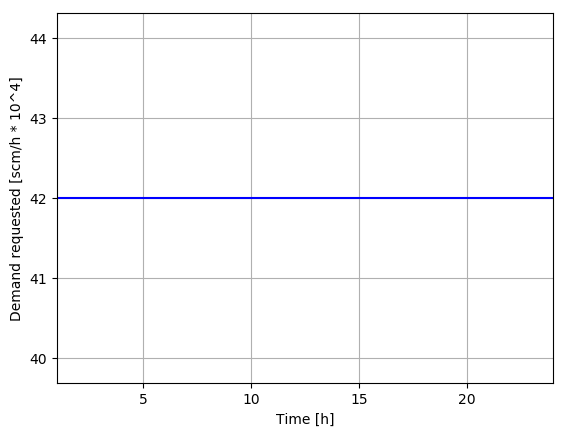

In [6]:
gas_demands = fill(42.0,length(time_grid))
#gas_demands[10:15] = 42*1.1
step(time_grid,gas_demands,color="blue")
ax = gca()
ax[:set_xlim]([1,24])
xlabel("Time [h]")
ylabel("Demand requested [scm/h * 10^4]")
grid("on")

## Setup network information

In [7]:
links = 1:13              #define set of pipelines 
plinks = [1,13]           #define passive pipelines
alinks = collect(2:12)    #define active pipelines
nodes = 1:14              #define set of nodes
supplies = [1]            #define set of supplies
demands = [1]             #define set of demands
supply_locs = [1]         #define node location of supply
demand_locs = [14]        #define node location of demand 
lstartloc = collect(1:13) #link start locations
lendloc = collect(2:14);  #link end locations

## Define pipeline transport variables
Notice how we have added a new index to each variable representing its link in the network

In [8]:
m = Model(solver = IpoptSolver())
@variable(m,pin[links,time_grid] >= 0, start = 60)
@variable(m,pout[links,time_grid] >= 0, start = 60)
@variable(m,fin[links,time_grid] >=0, start = 100)
@variable(m,fout[links,time_grid] >= 0, start = 100)
@variable(m, px[links,time_grid,x_grid] >= 0, start = 60)
@variable(m, fx[links,time_grid,x_grid] >= 0, start = 10)
@constraint(m, flow_in[link = links,t = time_grid],  fx[link,t,1] == fin[link,t])
@constraint(m, flow_out[link = links,t = time_grid], fx[link,t,x_grid[end]] == fout[link,t]);

## Supply and demand variables and constraints

In [9]:
# supply and demand variables
@variable(m, 34 <= pressure[nodes,time_grid] <= 70, start = 50)

#Fix supply pressure; give range for demand pressure
@constraint(m, fixsupplypressure[n = supply_locs,t = time_grid],pressure[n,t] == 54)
@constraint(m, demandpressure[n = demand_locs,t = time_grid], 39 <= pressure[n,t] <= 41)

@variable(m,0 <= sgen[supplies,time_grid] <= 125, start = 100)
@variable(m,ddeliver[demands,time_grid] >= 0, start = 100)
@variable(m, dtarget[demands,time_grid] >= 0)
@constraint(m, gasLimit[d = demands,t = time_grid], ddeliver[d,t] <= dtarget[d,t]);
@constraint(m, demand[d = demands,t = time_grid], dtarget[d,t] == gas_demands[t]);

## Compressor variables and equations

In [10]:
@variable(m, 1 <= dp[link = alinks,time_grid] <= 20 , start = 10)
@variable(m, 1 <= pow[link = alinks,time_grid] <= 10000, start = 500);
@NLconstraint(m,powereqn[link = alinks,t = time_grid], 
pow[link,t] == c4*fin[link,t]*(((pin[link,t]+dp[link,t])/pin[link,t])^om-1));

## Define PDE equations
Here we define the isothermal euler equations, as well as the appropriate boundary conditions and initial condition for EACH pipeline

In [35]:
#Auxillary variables
# @variable(m, slack1[links,time_grid,x_grid] >= 0, start = 10)  #auxiliary variable for friction loss term
# @variable(m, slack2[links,time_grid,x_grid] >= 0, start = 10)  #auxiliary variable
# @variable(m, slack3[links,time_grid,x_grid] >= 0, start = 10)  #auxiliary variable

# #Auxillary constraints (let's us avoid the fractional terms)
# @NLconstraint(m, slackeq1[link = links,t = time_grid, x = x_grid],  
# slack1[link,t,x]*px[link,t,x] - c3*fx[link,t,x]*fx[link,t,x] == 0)
# @NLconstraint(m, slackeq2[link = links,t = time_grid, x = x_grid],  
# slack2[link,t,x]*px[link,t,x] - 2*c1*fx[link,t,x] == 0)
# @NLconstraint(m, slackeq3[link = links,t = time_grid, x = x_grid],  
# slack3[link,t,x]*px[link,t,x]*px[link,t,x] - c1*fx[link,t,x]*fx[link,t,x] == 0)

# #PDE equations
# @constraint(m, mass[link = links,t = time_grid[1:end-1], x = x_grid[1:end-1]],
#     (px[link,t+1,x]-px[link,t,x])/dt + c1*(fx[link,t+1,x+1]-fx[link,t+1,x])/dx == 0 )
# @constraint(m, momentum[link = links,t = time_grid[1:end-1], x = x_grid[1:end-1]],
#     (fx[link,t+1,x]-fx[link,t,x])/dt == -slack2[link,t+1,x]*(fx[link,t+1,x+1]-fx[link,t+1,x])/dx +
#                             slack3[link,t+1,x]*(px[link,t+1,x+1]-px[link,t+1,x])/dx -c2*(px[link,t+1,x+1]-px[link,t+1,x])/dx - slack1[link,t+1,x])
#Adiabatic Approximation (This solves ~10x faster than the full euler equations)

In [11]:
#Auxillary variables

@variable(m, slack1[links,time_grid,x_grid] >= 0, start = 10)  #auxiliary variable for friction loss term
@NLconstraint(m, slackeq[link = links,t = time_grid, x = x_grid],  slack1[link,t,x]*px[link,t,x] - c3*fx[link,t,x]*fx[link,t,x] == 0)


# #PDE equations
@constraint(m, mass[link = links,t = time_grid[1:end-1], x = x_grid[1:end-1]], (px[link,t+1,x]-px[link,t,x])/dt + c1*(fx[link,t+1,x+1]-fx[link,t+1,x])/dx[link] == 0 )
@constraint(m, momentum[link = links,t = time_grid[1:end-1], x = x_grid[1:end-1]], 0 == -c2*(px[link,t+1,x+1]-px[link,t+1,x])/dx[link] - slack1[link,t+1,x])

#Boundary Conditions
#@constraint(m,f_in[t = time_grid],  fin[t] == 80)
@constraint(m,press_in1[link = plinks,t = time_grid], px[link,t,1] == pin[link,t])
@constraint(m,press_in2[link = alinks,t = time_grid], px[link,t,1] == pin[link,t] + dp[link,t])
@constraint(m,press_out[link = links,t = time_grid], px[link,t,x_grid[end]] == pout[link,t])
@constraint(m,press_boundary1[link = links,t = time_grid],pin[link,t] == pressure[lstartloc[link],t])
@constraint(m,press_boundary2[link = links,t = time_grid],pout[link,t] == pressure[lendloc[link],t])

#Initial Conditions
@constraint(m, mass_ss[link = links,t = 1, x = x_grid[1:end-1]],
(fx[link,t,x+1] - fx[link,t,x]) == 0)
@constraint(m, momentum_ss[link = links,t = 1, x = x_grid[1:end-1]], 
-c2*(px[link,t,x+1] - px[link,t,x])/dx[link] - slack1[link,t,x] == 0);

## Node conservation
We now introduce a mass balance for gas around each node in the network

In [12]:
# node balances
@constraint(m,nodebalance[node = nodes,t = time_grid],
sum(fout[link,t] for link in links if lendloc[link] == node)
+ sum(sgen[supply,t] for supply in supplies if supply_locs[supply] == node)
- sum(fin[link,t] for link in links if lstartloc[link] == node)
- sum(ddeliver[demand,t] for demand in demands if demand_locs[demand] == node) == 0);

## Periodic terminal constraint
This avoids solutions that deplete the mass of gas in the pipeline

In [13]:
#Periodic terminal constraint
@variable(m,linepack[links,time_grid])
@constraint(m,linepack_def[link = links,t = time_grid],linepack[link,t] == sum(fx[link,t,x] for x in x_grid)*dx[link]);
@constraint(m,linepack_cons[link = links], linepack[link,time_grid[end]] >= linepack[link,time_grid[1]]);

## Objective function terms

In [14]:
compressor_cost = 0.1
@variable(m, powercost[alinks])
@constraint(m,boostcosteqn[link = alinks], powercost[link] == sum(compressor_cost*pow[link,t] for t = time_grid)*dt/3600)

gas_cost = 1000
@variable(m, demandcost[demands])
@constraint(m, integratedGasCost[d = demands], demandcost[d] == sum(gas_cost*ddeliver[d,t] for t = time_grid));

## Objective function
Minimize total compressor power and maximize total gas delivered throughout the network

In [15]:
@objective(m,Min,sum(powercost[link] for link in alinks) - sum(demandcost[d] for d in demands));

## Solve problem

In [16]:
solve(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    14456
Number of nonzeros in inequality constraint Jacobian.:       98
Number of nonzeros in Lagrangian Hessian.............:     5328

Total number of variables............................:     5316
                     variables with only lower bounds:     4104
                variables with lower and upper bounds:      888
                     variables with only upper bounds:        0
Total number of equa

:Optimal

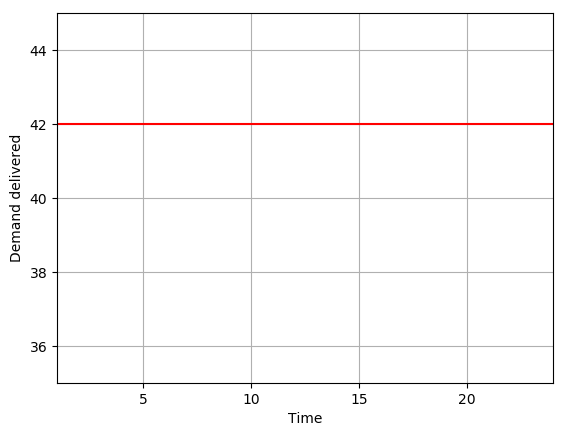

In [42]:
d_profile = getvalue(ddeliver)
step(time_grid,d_profile[:],color="red")
ax = gca()
ax[:set_xlim]([1,24])
ax[:set_ylim]([35,45])
xlabel("Time [h]")
ylabel("Demand delivered [scm/h * 10^4]")
grid("on")

In [17]:
pressure_profile = Matrix(length(time_grid),0)
flow_profile = Matrix(length(time_grid),0)
for link in links
    p = getvalue(px[link,:,:])
    f = getvalue(fx[link,:,:])
    pressure_profile = [pressure_profile p]
    flow_profile = [flow_profile f]
end
x_plot = linspace(0,1700,length(x_grid)*13)

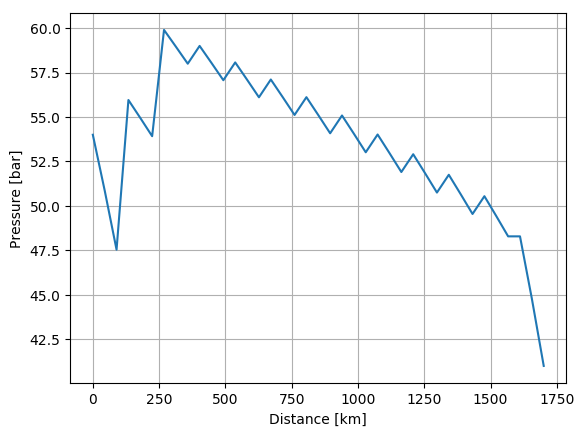

In [18]:
plot(x_plot,pressure_profile[1,:])
xlabel("Distance [km]")
ylabel("Pressure [bar]")
grid("on")

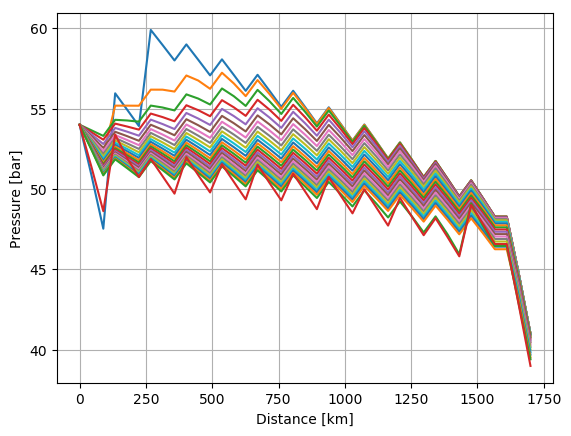

In [19]:
for t = time_grid
    plot(x_plot,pressure_profile[t,:])
end
xlabel("Distance [km]")
ylabel("Pressure [bar]")
grid("on")

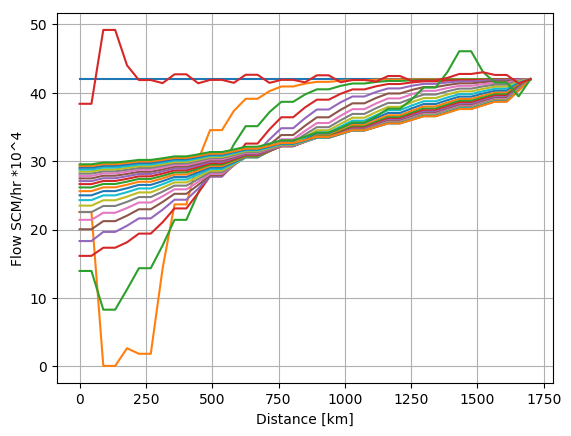

In [20]:
for t = time_grid
    plot(x_plot,flow_profile[t,:])
end
xlabel("Distance [km]")
ylabel("Flow SCM/hr *10^4")
grid("on")